In [2]:
import os
import re
from skimage.transform import resize, rotate
from skimage.morphology import disk, binary_dilation, skeletonize
from skimage.filters.rank import sum, mean
from skimage.filters import sobel_h, sobel_v, sobel, gaussian
from skimage.exposure import adjust_gamma
from skimage.color import gray2rgb, rgb2gray
from skimage.measure import regionprops
from scipy.spatial.distance import euclidean as distancia
import glob
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


ROOT = os.path.abspath('imgs')

lista_archivos = glob.glob(ROOT + '/*')
nombres_unicos = {re.findall(r'(\d+_\d+)', a)[0] for a in lista_archivos}
dict_archivos = {u: [a for a in lista_archivos if os.path.basename(a).startswith(u)] for u in nombres_unicos}

In [58]:
## Funciones
def abrir_img(path, shape=None):
    img = PIL.Image.open(path)
    if shape is not None:
        img = img.resize(shape)
    return np.array(img)

def adjust(img):
    im = 0.8*img[...,1]+0.2*img[...,2]
    def gauss(v, u, sigma = 200):
        return np.exp(-(v-u)**2/(2*sigma**2))
    x = np.arange(im.shape[1])
    y = np.arange(im.shape[0])
    X, Y = np.meshgrid(x,y)
    Z = gauss(X, im.shape[1]//2) + gauss(Y, im.shape[0]//2)
    adjusted = im*Z
    return adjusted / np.max(adjusted)

def get_optical_disk_center(im, t=0.92, scale=0.3): 
    if scale!=1:
        shape_scaled = [int(s*scale) for s in im.shape[:2]]
        im = resize(im, shape_scaled, anti_aliasing=True)
    im = adjust(im)
    im_bin = im > t
    im_bin = binary_dilation(im_bin, disk(10))
    regions = regionprops(im_bin*1)
    return [int(v/scale) for v in regions[0].centroid]# cy, cx

def draw_arrows(dx, dy, ax, s=2.3):
    kwargs = {
        'width' : 0.05
    }
    for i in range(dx.shape[0]):
        for x in range(dx.shape[1]):
            y = i
            ax.arrow(x,y, dx[i,x]*s, dy[i,x]*s,
                    **kwargs)
            
def extraer_region(img, cy, cx, long=21):
    assert min(img.shape)>=10
    max_y = img.shape[1]
    x0 = cx-long//2
    y0 = min(cy-long//2, max_y-long)
    return img[y0:y0+long,
               x0:x0+long]

def calcular_angulo(reg, show=False):
    dy = sobel_h(reg)
    dx = sobel_v(reg)
    angs = np.abs(np.tan(dy/dx)*180/np.pi)
    angs = angs[angs<=90]
    if show:
        fig, ax = plt.subplots(1,2, figsize=(10,7))
        ax[0].imshow(reg)
        ax[1].imshow(reg)
        draw_arrows(dx,dy, ax[1])
        plt.title(f'{np.nanmean(angs)}')
        plt.show()
    return(np.nanmean(angs))

def encontrar_rotacion(reg, show=False):
    """
    Búsqueda exhaustiva del ángulo óptimo para realizar la rotación
    """
    x = np.linspace(-120,120, 100)
    y = [abs(calcular_angulo(rotate(reg, i))) for i in x]
    if show:
        plt.plot(x,y)
        plt.show()
    ordenados = sorted(zip(np.abs(x),y, np.arange(len(x))), key = lambda x: x[1])
    x_min = ordenados[0]
    x_cont=1
    while x_cont<10:
        if ordenados[x_cont][0] < x_min[0]:
            x_min = ordenados[x_cont]
        else:
            break
    return x[x_min[-1]]

class Grafica(nx.Graph):
    def armar_grafica(self, skl, clase=None):
        """
        Recibe la imagen del esqueleto y devuelve un objeto
        Graph con la representación gráfica de este
        """
        self.img_shape = skl.shape
        pixels = list(zip(*np.where(skl)))
        self.add_nodes_from(pixels, clase=clase)
        for cy,cx in pixels:
            neigh = skl[cy-1:cy+2, cx-1:cx+2]
            n_coords = [(cy+y-1,cx+x-1) for y,x in zip(*np.where(neigh))]            
            for y,x in n_coords:
                if (y,x)!=(cy,cx):
                    self.add_edge((y,x), (cy,cx))
                    
        self.buscar_puntos()
    
    def buscar_puntos(self):
        intersecs = []
        end_points = []
        for k,v in self.degree:
            if v==1:
                end_points.append(k)
            elif v>=3:
                intersecs.append(k)
        return(intersecs, end_points)
    
    def mostrar(self):
        fig, ax = plt.subplots()
        ax.imshow(np.zeros(self.img_shape))
        dibujar_puntos(ax, self.nodes)
        plt.show()

def dibujar_puntos(ax, pts, stl='w*'):
    y, x = list(zip(*pts))
    ax.plot(x,y, stl)
    



In [6]:
#np.random.seed(12)

X_data = []
Y_data = []
ventana = 250
padding = 0
for n, k in enumerate(list(dict_archivos.keys())[:1]):#enumerate(dict_archivos):#
    print(f'Abriendo imagen {n+1} ({k})')
    labels = []
    for i in dict_archivos[k]:
        if 'artery' in i: #Máscara de arterias
            b = abrir_img(i)*1.#tf.cast(abrir_img(i, img_shape)*1, tf.float32)
            b= np.pad(b,((padding,padding),(padding,padding)), mode='constant', constant_values=0)
            labels.insert(0, b)
        elif 'vein' in i: #Máscara de venas
            b = abrir_img(i)*1.#tf.cast(abrir_img(i, img_shape)*1, tf.float32)
            b= np.pad(b,((padding,padding),(padding,padding)), mode='constant', constant_values=0)
            labels.append(b)
        else:
            img = abrir_img(i)/255.
            img = np.pad(img,((padding,padding),(padding,padding), (0,0)), mode='constant', constant_values=0)
    
    #Se buscan las coordenadas donde hay vasos sanguíneos
    print('\t- Buscando el disco óptico...', end=' ')
    doy, dox = get_optical_disk_center(img)
    print(f' Encontrado en {(doy,dox)}')
    print('\t- Buscando las coordenadas válidas de búsqueda...')
    mask = (labels[0] + labels[1])/2.>0.1
    esqueleto = skeletonize(mask)
    coords = list(zip(*np.where(esqueleto)))
    np.random.shuffle(coords)
    G = Grafica()
    G.armar_grafica(esqueleto)
    print(len(G))
    
    
    """
    cy, cx = coords[0]
    reg = extraer_region(esqueleto, cy, cx, 21)
    reg = gaussian(reg, sigma=1)
    
    
    angulo = encontrar_rotacion(reg, show=True)
    reg[3,3]=1
    
    dy = int(ventana*0.8)
    dy_f = ventana - dy
    pad = int(0.3*ventana)
    vent = mask[cy-dy-pad:cy+dy_f+pad,
                cx-ventana//2-pad:cx+ventana//2+pad]
    rotado = rotate(vent, angulo, center =(ventana//2+pad, dy+pad))[pad:pad+ventana,
                                                                    pad:pad+ventana]
    
    
    f, ax = plt.subplots(3,2, figsize=(10,15))
    ax = ax.ravel()
    ax[0].imshow(esqueleto[cy-dy:cy+dy_f,
                cx-ventana//2:cx+ventana//2])
    ax[1].imshow(mask[cy-dy:cy+dy_f,
                cx-ventana//2:cx+ventana//2])
    ax[2].imshow(reg)
    ax[3].imshow(rotate(reg, angulo))
    ax[4].imshow(vent)
    ax[5].imshow(rotado)
    plt.suptitle(f'{angulo}')
    plt.show()
    """
"""
Implementar el flujo de trabajo:
* extraer una región cercana al punto
* Calcular el ángulo de rotación
* Extraer una ventana más grande
* Rotar esa ventana
* Posicionar el punto en la parte inferior
""";


Abriendo imagen 1 (1_000)
	- Buscando el disco óptico...  Encontrado en (1995, 1324)
	- Buscando las coordenadas válidas de búsqueda...
46843


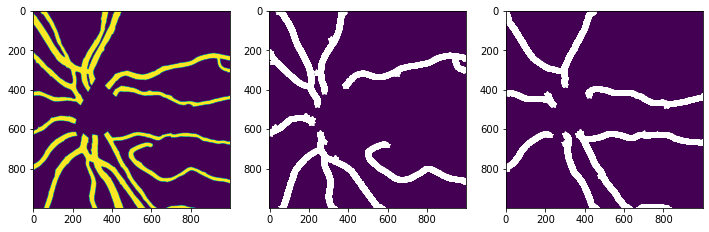

In [59]:
def limpiar_ramas(G, long_min=50):
    inter, _ = G.buscar_puntos()
    def recorrer(n0, nd):
        sig = [n for n in G[nd] if n!=n0 and G.degree[n]<2]
        print(sig)
        

do_vent = 1000
preds = np.zeros([do_vent, do_vent]+[3])
new_labels = [mask] + labels
for l in range(3):
    preds[...,l] = new_labels[l][doy-do_vent//2:doy+do_vent//2,
                                 dox-do_vent//2:dox+do_vent//2]

gven, gart = Grafica(), Grafica()

gart.armar_grafica(skeletonize(preds[..., 1]))
gven.armar_grafica(skeletonize(preds[..., 2]))
limpiar_ramas(gart, 100)
limpiar_ramas(gven)

blank_img = np.zeros_like(preds[...,0])
f, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(preds[..., 0])
axs[1].imshow(blank_img)
dibujar_puntos(axs[1], gart.nodes)
axs[2].imshow(blank_img)
dibujar_puntos(axs[2], gven.nodes)
plt.show()

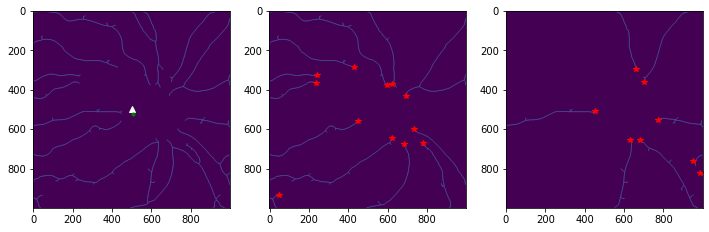

In [30]:
def ajustar_cdo(pts): #Ajustar el centro del disco óptico
    y, x = list(zip(*pts))
    new_x = np.mean(x)
    new_y = np.mean(y)
    return new_y, new_x

def selec_puntos_do(G, cdo, umbral0 = 300):
    """
    Busca los puntos finales más cercanos al Disco Óptico.
    Elimina todos aquellos que se encuentren más lejanos y 
    que tengan conexión con otro punto.
    """
    _, pts = G.buscar_puntos()
    aprox1 = [p for p in pts if distancia(p, cdo)<umbral0]
    new_cdo = ajustar_cdo(aprox1)
    ##Prueba exhaustiva para eliminar nodos que no sean los
    ## más cercanos al DO y que no pertenezcan a la misma rama
    mejores = set()
    for p1 in pts:
        mejor = p1
        for p2 in pts:
            if nx.has_path(G, mejor, p2):
                mejor = sorted((mejor, p2), key=lambda x: distancia(x, (new_cdo)))[0]
        mejores.add(mejor)
    return list(mejores)

do_art_pts = selec_puntos_do(gart, (500,500))
do_ven_pts = selec_puntos_do(gven, (500,500))


f, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(skeletonize(preds[..., 0]))
ax[0].plot([500], [500], 'w^')
new_y, new_x = ajustar_cdo(endpts)
ax[0].plot([new_x], [new_y], 'g.')
ax[1].imshow(skeletonize(preds[..., 1]))
dibujar_puntos(ax[1], do_art_pts)
#ax[1].plot([cdo_art[1]], [cdo_art[0]], 'g.')
ax[2].imshow(skeletonize(preds[..., 2]))
dibujar_puntos(ax[2], do_ven_pts)
#ax[2].plot([cdo_ven[1]], [cdo_ven[0]], 'g.')
plt.show()


## Buscar las intersecciones más próximas
#for pt in do_pts_aprox:
#    has_paths = [nx.has_path(gmask, pt, p) for p in inter]
#    print(pt, [inter[i] for i, has in enumerate(has_paths) if has])

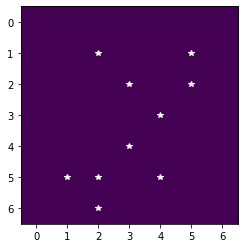

(3, 4) (2, 3)
{(2, 3), (1, 2)}
(3, 4) (2, 5)
{(2, 5), (1, 5)}
(3, 4) (4, 3)
set()
(4, 3) (3, 4)
set()
(4, 3) (5, 2)
set()
(4, 3) (5, 4)
{(5, 4)}
(5, 2) (4, 3)
set()
(5, 2) (5, 1)
{(6, 2), (5, 1)}
(5, 2) (6, 2)
{(6, 2), (5, 1)}


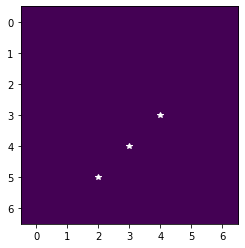

In [63]:
##Probar la función de la gráfica                         
def limpiar_ramas(G, long_min=10):
    inter, _ = G.buscar_puntos()
    por_eliminar = set()
    def recorrer(n0, nd):
        visitados = [n0, nd]
        while True:
            ult = visitados[-1]
            if G.degree[ult]>2: return set()
            sig = [n for n in G[ult] if n!=n0]
            #print('siguiente', sig, list(G[ult]))
            if len(sig)==0 or len(visitados)>long_min:
                break
            else:
                visitados.append(sig[0])
        return set(visitados[1:])
    #print(inter)
    for i in inter:
        adj = list(G[i])
        for a in adj:
            print(i, a)
            rama =recorrer(i, a) 
            print(rama)
            por_eliminar = por_eliminar.union(rama)
            
    G.remove_nodes_from(por_eliminar)
    
#                 0 1 2 3 4 5 6
esqu = np.array([[0,0,0,0,0,0,0],#0
                 [0,0,1,0,0,1,0],#1
                 [0,0,0,1,0,1,0],#2
                 [0,0,0,0,1,0,0],#3
                 [0,0,0,1,0,0,0],#4
                 [0,1,1,0,1,0,0],#5
                 [0,0,1,0,0,0,0]])#6
g = Grafica()
g.armar_grafica(esqu)
g.mostrar()
limpiar_ramas(g, 3)
g.mostrar()